In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [33]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [13]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [14]:
# Lookup table
C = torch.randn((27, 2))

In [15]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [18]:
import torch.nn.init as init

# Modify the initialization of W1 and b1
W1 = torch.empty(6, 100)
init.uniform_(W1, -1, 1)
b1 = torch.empty(100)
init.uniform_(b1, -1, 1)

In [19]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [20]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [21]:
logits = h @ W2 + b2

In [22]:
logits.shape

torch.Size([32, 27])

## Workflow made respectable

In [169]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
# random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182587, 4]) torch.Size([182587])
torch.Size([22709, 4]) torch.Size([22709])
torch.Size([22850, 4]) torch.Size([22850])


In [153]:
Xtr.shape, Ytr.shape #dataset

(torch.Size([182383, 4]), torch.Size([182383]))

In [178]:
# g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
# W1 = torch.randn((40, 300), generator=g) # 100 hidden layer neurons
# b1 = torch.randn(300, generator=g)
# W2 = torch.randn((300, 27), generator=g)
# b2 = torch.randn(27, generator=g)

W1 = torch.randn((40, 300), generator=g) # 100 hidden layer neurons
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [171]:
sum(p.nelement() for p in parameters) # number of parameters in total

20697

In [172]:
for p in parameters:
    p.requires_grad = True

In [157]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [173]:
lri, lossi = [], []
stepi = []

In [174]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (128,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        # lr = lrs[i]
        lr = 0.1 if i < 100000 else 0.01
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())

2.3874130249023438


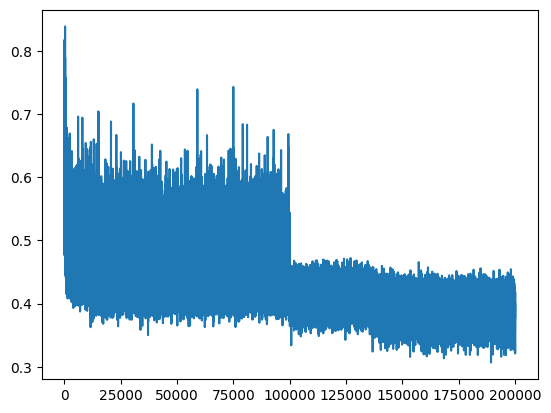

In [175]:
plt.plot(stepi, lossi)

In [176]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4516, grad_fn=<NllLossBackward0>)

In [177]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4494, grad_fn=<NllLossBackward0>)

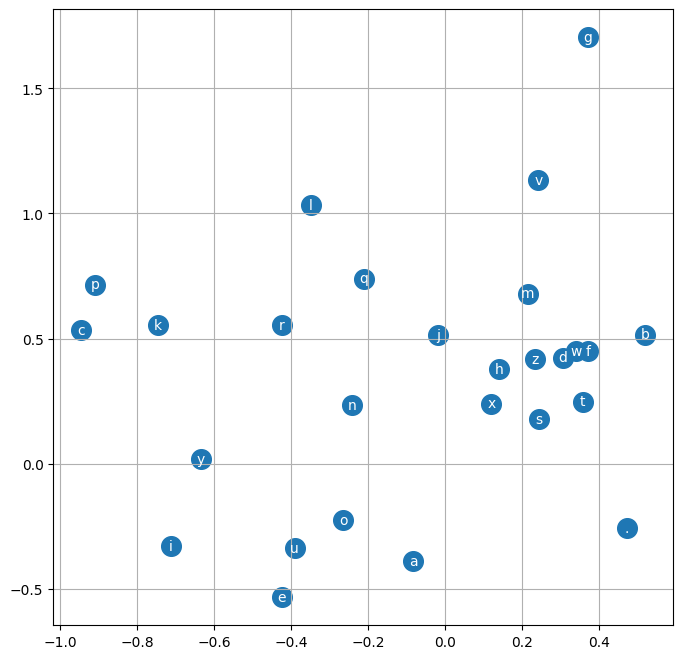

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [168]:
# sample from the model
# g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

braia.
judhana.
reshya.
kosha.
cobrinitai.
pemweluc.
zois.
famia.
dinra.
alani.
cameri.
corekaron.
atamari.
colyn.
keriyah.
cari.
asejuw.
lonna.
muif.
kassina.
